In [1]:
from six.moves import urllib, xrange

import tensorflow as tf
import numpy as np
import string, re
import collections, math, os, random, zipfile
from sklearn.datasets import fetch_20newsgroups

In [2]:
def read_data(filename):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    data = []
    for document in filename:
        temp = regex.sub('', document).split()
        data.extend(temp) 
    return data

In [3]:
newsgroup = fetch_20newsgroups(data_home='../Data')
news_data = newsgroup.data
wordlist = read_data(news_data)

In [4]:
# build the dictionary and replace rare words with the "UNK" token.
vocabulary_size = 50000

def build_dataset(words):
    # create counts list, set counts for "UNK" token to -1 (undefined)
    count = [['UNK', -1]]
    # add counts of the 49,999 most common tokens in 'words'
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # create the dictionary data structure
    dictionary = {}
    # give a unique integer ID to each token in the dictionary
    for word, _ in count:
        dictionary[word] = len(dictionary)
    # create a list data structure for the data
    data = []
    # keep track of the number of "UNK" token occurrences
    unk_count = 0
    # for each word in our list of words
    for word in words:
        # if its in the dictionary, get its index
        if word in dictionary:
            index = dictionary[word]
        # otherwise, set the index equal to zero (index of "UNK") and increment the "UNK" count
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        # append its index to the 'data' list structure
        data.append(index)
    # set the count of "UNK" in the 'count' data structure
    count[0][1] = unk_count
    # invert the dictionary; it becomes (index, word) key-value pairs
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    # return the data (indices), counts, dictionary, and inverted dictionary
    return data, count, dictionary, reverse_dictionary

# build the datset
data, count, dictionary, reverse_dictionary = build_dataset(wordlist)
# free up some memory
del wordlist
# print out stats
print('most common words (+UNK):', count[:10])
print('sample data:', data[:10], [reverse_dictionary[i] for i in data[:10]])

most common words (+UNK): [['UNK', 135883], ('the', 129511), ('to', 71209), ('of', 67563), ('a', 56958), ('and', 54149), ('is', 41275), ('I', 40824), ('in', 38906), ('that', 36458)]
sample data: [24, 0, 19677, 42, 210, 25, 6376, 272, 6, 20] ['From', 'UNK', 'wheres', 'my', 'thing', 'Subject', 'WHAT', 'car', 'is', 'this']


In [5]:
data_index = 0

# generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    # make sure our parameters are self-consistent
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    # create empty batch ndarray using 'batch_size'
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    # create empty labels ndarray using 'batch_size'
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # [ skip_window target skip_window ]
    span = 2 * skip_window + 1
    # create a buffer object for prepping batch data
    buffer = collections.deque(maxlen=span)
    # for each element in our calculated span, append the datum at 'data_index' and increment 'data_index' moduli the amount of data
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # loop for 'batch_size' // 'num_skips'
    for i in range(batch_size // num_skips):
         # target label at the center of the buffer
        target = skip_window
        targets_to_avoid = [skip_window]
        # loop for 'num_skips'
        for j in range(num_skips):
            # loop through all 'targets_to_avoid'
            while target in targets_to_avoid:
                # pick a random index as target
                target = random.randint(0, span - 1)
            # put it in 'targets_to_avoid'
            targets_to_avoid.append(target)
            # set the skip window in the minibatch data
            batch[i * num_skips + j] = buffer[skip_window]
            # set the target in the minibatch labels
            labels[i * num_skips + j, 0] = buffer[target]
        # add the data at the current 'data_index' to the buffer
        buffer.append(data[data_index])
        # increment 'data_index'
        data_index = (data_index + 1) % len(data)
    # return the minibatch data and corresponding labels
    return batch, labels

# get a minibatch
batch, labels = generate_batch(batch_size=16, num_skips=2, skip_window=1)

# print out part of the minibatch to the console
for i in range(16):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

0 UNK -> 19677 wheres
0 UNK -> 24 From
19677 wheres -> 42 my
19677 wheres -> 0 UNK
42 my -> 19677 wheres
42 my -> 210 thing
210 thing -> 42 my
210 thing -> 25 Subject
25 Subject -> 6376 WHAT
25 Subject -> 210 thing
6376 WHAT -> 272 car
6376 WHAT -> 25 Subject
272 car -> 6376 WHAT
272 car -> 6 is
6 is -> 272 car
6 is -> 20 this


In [23]:
# hyperparameters
batch_size = 128
embedding_size = 300 # dimension of the embedding vector
skip_window = 1 # how many words to consider to left and right
num_skips = 2 # how many times to reuse an input to generate a label

# we choose random validation dataset to sample nearest neighbors
# here, we limit the validation samples to the words that have a low
# numeric ID, which are also the most frequently occurring words
valid_size = 16 # size of random set of words to evaluate similarity on
valid_window = 100 # only pick development samples from the first 'valid_window' words
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64 # number of negative examples to sample

# create computation graph
graph = tf.Graph()

with graph.as_default():
    # input data
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.placeholder(dtype=tf.int32)
    
    # operations and variables
    # look up embeddings for inputs
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each time we evaluate the loss.
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                     labels=train_labels, inputs=embed, num_sampled=num_sampled, num_classes=vocabulary_size))
    
    # construct the SGD optimizer using a learning rate of 1.0
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # compute the cosine similarity between minibatch examples and all embeddings
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # add variable initializer
    init = tf.global_variables_initializer()

In [24]:
# steps to train the model
num_steps = 100001
session = tf.Session(graph=graph)
with session.as_default():
    # we must initialize all variables before using them
    init.run()
    print('initialized.')
    
    # loop through all training steps and keep track of loss
    average_loss = 0
    for step in xrange(num_steps):
        # generate a minibatch of training data
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        # we perform a single update step by evaluating the optimizer operation (including it
        # in the list of returned values of session.run())
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        # print average loss every 2,000 steps
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # the average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
        
        # computing cosine similarity (expensive!)
        if step % 10000 == 0:
            sim = similarity.eval(feed_dict={ valid_dataset : valid_examples})
            for i in xrange(valid_size):
                # get a single validation sample
                valid_word = reverse_dictionary[valid_examples[i]]
                # number of nearest neighbors
                top_k = 8
                # computing nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
        
    final_embeddings = normalized_embeddings.eval()

initialized.
Average loss at step  0 :  279.716308594
nearest to all: HUGE, symbol, Soccer, PFSWrite, Investigation, Hubbard, FLYER, guerrilla,
nearest to an: crux3citcornelledu, Jonny, booming, 0577, NetLink, sprayed, administered, RIPEMs,
nearest to also: rubble, game, Aharonian, joetrysteroartcom, Selanne, 74L, exhibited, garrison,
nearest to dont: molecular, excellent, Solun, lamp, 130mph, fistiscpbellcorecom, 0455, Product,
nearest to on: CANT, defensible, Jewish, barbecuing, meg, subaru, Viewed, implementing,
nearest to the: EnviroLeague, strawberry, locking, MORBUS, flubberccutexasedu, CSM, 443, prevent,
nearest to their: ASVXFforsythestanfordedu, fete, Something, pulchritude, Attention, physician, Set, Win31,
nearest to other: frogsarvaxcmhnetorg, simms, clubs, Bentsen, Toolbook, functions, areaýé, tensions,
nearest to MAXAXAXAXAXAXAXAXAXAXAXAXAXAXAX: 1949, Bank, Copperud, Tv, preexisting, smithctroncom, jimgcybernetcsefauedu, Mankato,
nearest to no: urge, XUseragent, Asente, R

Average loss at step  52000 :  10.51112779
Average loss at step  54000 :  12.0742515133
Average loss at step  56000 :  12.7099425061
Average loss at step  58000 :  7.44321353322
Average loss at step  60000 :  6.55935230422
nearest to all: getting, these, only, covered, what, saying, ago, some,
nearest to an: stand, compression, actually, McNall, the, DDG, grow, He,
nearest to also: still, just, havent, actually, game, not, already, only,
nearest to dont: can, didnt, would, should, will, cant, must, cannot,
nearest to on: from, and, about, into, upon, for, at, in,
nearest to the: libXmulibXmuso, 1, graphicdisplay, Arf, Keown, OFF, MR535, jle,
nearest to their: his, our, my, the, your, her, them, its,
nearest to other: more, of, case, way, have, one, had, without,
nearest to MAXAXAXAXAXAXAXAXAXAXAXAXAXAXAX: ksec, MOTECC91, libXmulibXmua, px, mv, APRS, jle, 9P,
nearest to no: any, only, considered, theres, some, which, actually, given,
nearest to or: and, than, but, for, had, from, inform

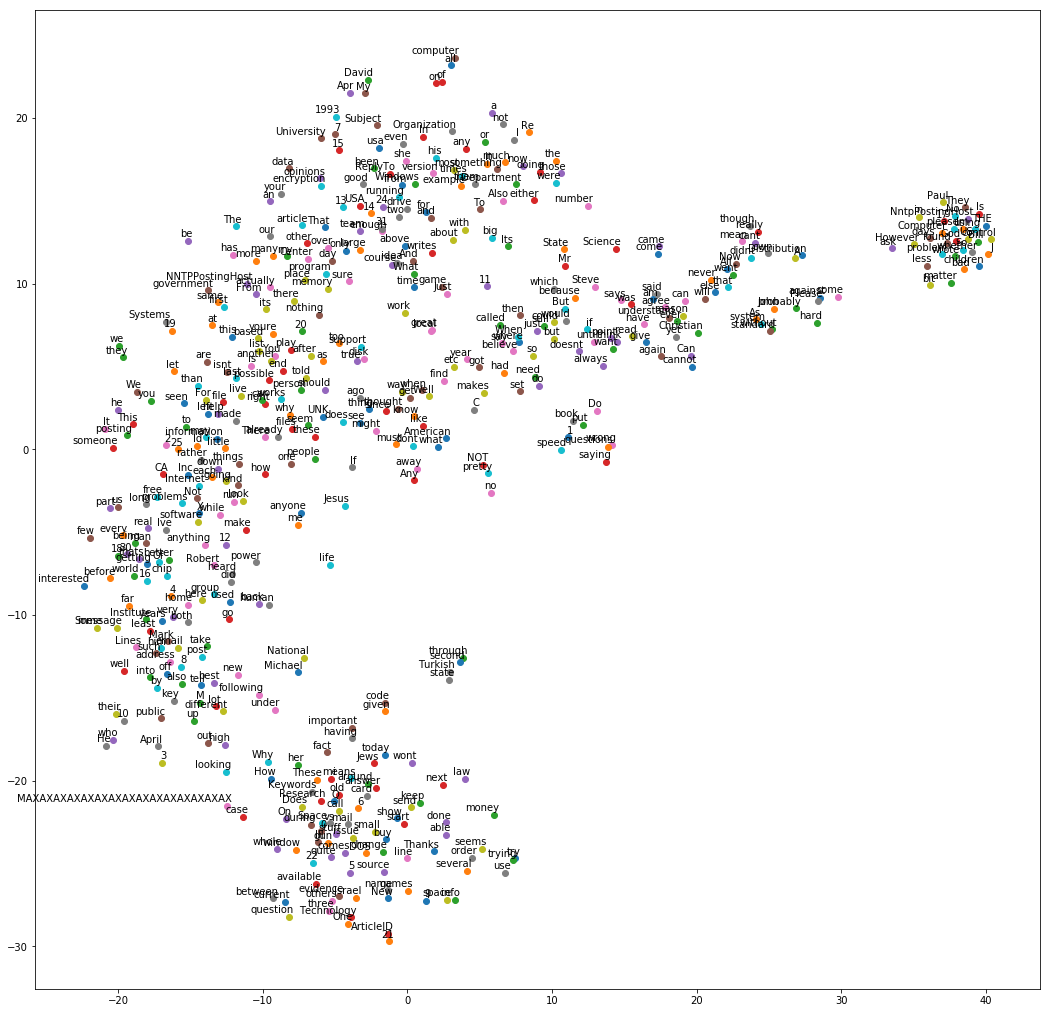

In [8]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    # set plot size in inches
    plt.figure(figsize=(18, 18))
    # loop through all labels
    for i, label in enumerate(labels):
        # get the embedding vectors
        x, y = low_dim_embs[i, :]
        # plot them in a scatterplot
        plt.scatter(x, y)
        # annotations
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    # save the figure out
    #plt.savefig(filename)
    plt.show()

#try:
# import t-SNE and matplotlib.pyplot
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

# create the t-SNE object with 2 components, PCA initialization, and 5000 iterations
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
# plot only so many words in the embedding
plot_only = 500
# fit the TSNE dimensionality reduction technique to the word vector embedding
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
# get the words associated with the points
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
# call the plotting function
plot_with_labels(low_dim_embs, labels)


In [38]:
def nearst_words(word):
    valid_examples = [dictionary[word]]
    with session.as_default():
        sim = similarity.eval(feed_dict ={ valid_dataset : valid_examples})
        #print(sim.shape)
        # get a single validation sample
        valid_word = reverse_dictionary[valid_examples[0]]
        # number of nearest neighbors
        top_k = 20
        # computing nearest neighbors
        nearest = (-sim[0, :]).argsort()[1:top_k + 1]
        log_str = "nearest to %s:" % valid_word
        for k in xrange(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log_str = "%s %s," % (log_str, close_word)
        print(log_str)

In [39]:
nearst_words('hi')

nearest to hi: lXmu, blanketbombing, Rasulov, 1833, clue, IIFX, Stilgar, App, definetly, rodents, purview, ruckmanoasysdtnavymil, September, membranes, tailor, 0412, jgreentrumpetcalpolyedu, flora, burstfire, Teams,


In [ ]:
session.close()